In [1]:
from utils import data_loader, data_table
from skeletons import training_skeleton, autoencoder_skeleton
import glob
import models
import os
import numpy as np

Using TensorFlow backend.


### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [2]:
# get h5 datasets
samples = glob.glob("../data/hlfSVJ/*_data.h5")
loader = data_loader("main sample")
for sample in samples:
    loader.add_sample(sample)

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/hlfSVJ/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/hlfSVJ/7_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/hlfSVJ/8_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/hlfSVJ/5_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/hlfSVJ/6_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
dat

Note that we normalize our training/testing each with respect to the full data sample:

In [3]:
data = loader.make_table()
train, test = data.train_test_split(0.5)
train_norm, test_norm = data.norm(train), data.norm(test)

data_loader :: Grabbing dataset with keys [u'event_feature_data']


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['main sample', 'train', 'test']


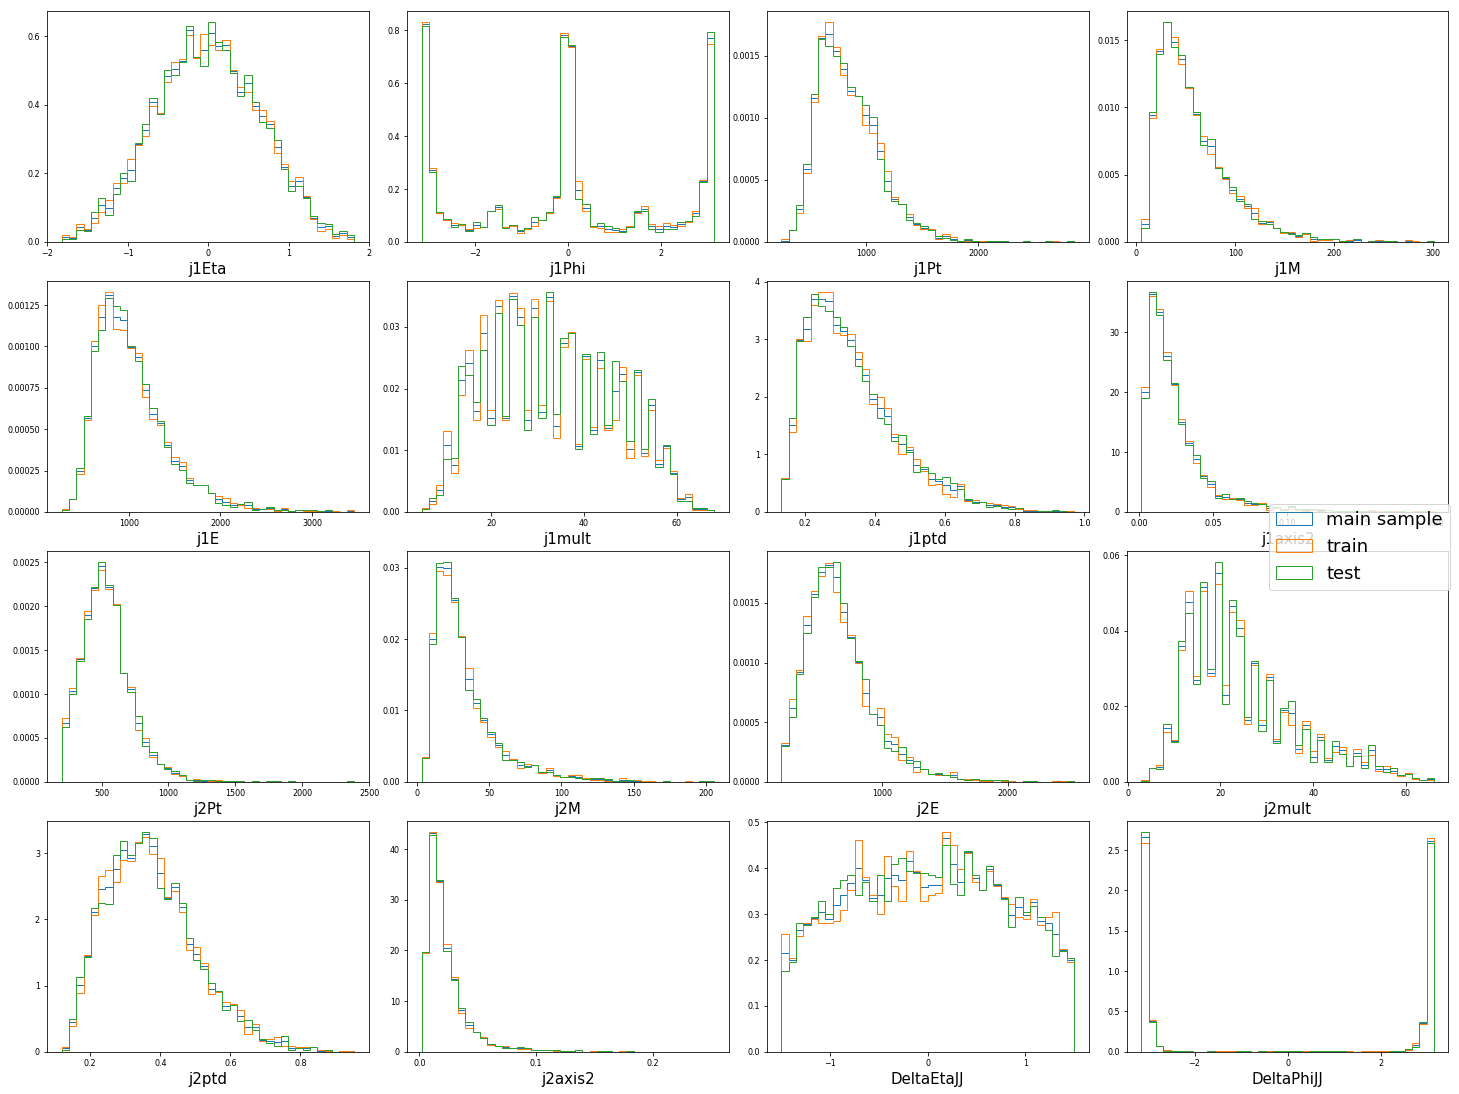

In [4]:
data.plot([train, test], normed=1, bins=40, figsize=(20,15), fontsize=15)

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [5]:
autoencoder = models.shallow(bn=5, n_features=data.shape[1])
encoder, decoder = autoencoder.layers[1:]

... and the model summaries:

In [6]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()

encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
layer_2 (Dense)              (None, 5)                 85        
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
layer_3 (Dense)              (None, 16)                96        
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


autoencoder summary:
_________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [7]:
name = "shallow_5"
trainer = training_skeleton(os.path.join("data/training_runs/16hlf", name))

train_shell :: locking file '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/16hlf/shallow_5.h5'
h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'shallow_5.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'shallow_5.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'shallow_5.h5'
h5_elt 'acc' :: loading dataset 'metric_names/acc' from file 'shallow_5.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'shallow_5.h5'
h5_elt 'val_acc' :: loading dataset 'metric_names/val_acc' from file 'shallow_5.h5'
h5_elt 'val_loss' :: loading dataset 'metric_names/val_loss' from file 'shallow_5.h5'


the `training_skeleton` object locks the file it works on while it trains, meaning you cannot have duplicates:

In [8]:
try:
    duplicate = training_skeleton(os.path.join("data/training_runs/16hlf", name))
except AttributeError as e:
    print e

train_shell :: ERROR: filename '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/16hlf/shallow_5.h5' is already being edited in another instance!!
filename '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/16hlf/shallow_5.h5' is already being edited in another instance!!
train_shell :: unlocking file 'shallow_5.h5'


training is easy:

In [9]:
autoencoder = trainer.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adadelta",
    loss="mse",
    epochs=10,
    model=autoencoder,
    metrics=['accuracy'],
    force=False
)

train_shell :: ERROR: IGNORING PASSED PARAMETER 'model'
train_shell :: using saved model
train_shell :: TRAINING EPOCH 20/30
Train on 2809 samples, validate on 2809 samples
Epoch 21/21
87/87 [==============================] - 1s 6ms/step - loss: 0.0105 - acc: 0.8333 - val_loss: 0.0103 - val_acc: 0.8167
train_shell :: TRAINING EPOCH 21/30
Train on 2809 samples, validate on 2809 samples
Epoch 22/22
87/87 [==============================] - 0s 4ms/step - loss: 0.0105 - acc: 0.8378 - val_loss: 0.0103 - val_acc: 0.8163
train_shell :: TRAINING EPOCH 22/30
Train on 2809 samples, validate on 2809 samples
Epoch 23/23
87/87 [==============================] - 0s 4ms/step - loss: 0.0105 - acc: 0.8329 - val_loss: 0.0103 - val_acc: 0.8135
train_shell :: TRAINING EPOCH 23/30
Train on 2809 samples, validate on 2809 samples
Epoch 24/24
87/87 [==============================] - 0s 4ms/step - loss: 0.0105 - acc: 0.8273 - val_loss: 0.0103 - val_acc: 0.8092
train_shell :: TRAINING EPOCH 24/30
Train on 2809 s

Training will also pick up where you left off, if at all possible - so make sure to delete unwanted models or change nomenclature when you want a new training session.

In [ ]:
autoencoder = trainer.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    optimizer="adam",
    loss="mse",
    epochs=10,
    verbose=0,
    metrics=['accuracy']
)

train_shell :: using saved model
train_shell :: TRAINING EPOCH 30/40
train_shell :: TRAINING EPOCH 31/40
train_shell :: TRAINING EPOCH 32/40


### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

In [ ]:
trainer.plot_metrics(fnmatch_criteria="*loss*", yscale="log")
trainer.plot_metrics(fnmatch_criteria="*acc*", yscale="linear")

checking results:

In [ ]:
reconstructed_norm = data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
reconstructed = data.inorm(reconstructed_norm)
reconstructed.name = "reconstructed"

train.plot([reconstructed], bins = 40)

### 5. reproduce
These results are saved for later and can be easily accessed with the h5 files saved, or using the training_skeleton instance:

In [ ]:
if "trainer" in locals():
    del trainer

tnew = training_skeleton("data/training_runs/16hlf/shallow_5")

In [ ]:
print tnew.loss